In [1]:
!pip install git+https://github.com/openai/CLIP.git
!pip install git+https://github.com/LAION-AI/CLAP.git
!pip install faiss-cpu
!pip install opencv-python
!pip install librosa
!pip install moviepy
!pip install transformers
!pip install torch torchvision torchaudio


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-62icdwqi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-62icdwqi
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 38.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
laion-clap 1.1.6 requires numpy<2.0.0,>=1.23.5, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
laion-clap 1.1.6 requires numpy<2.0.0,>=1.23.5, but you have numpy 2.0.2 which is incompatible.


# Extract Visual Features using CLIP



In [2]:
import clip
import torch
from PIL import Image
import torchvision.transforms as transforms
import cv2

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def extract_clip_features(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        frames.append(preprocess(img).unsqueeze(0))
    cap.release()

    frames_tensor = torch.cat(frames, dim=0).to(device)
    with torch.no_grad():
        features = model.encode_image(frames_tensor)
    return features.mean(dim=0)


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 59.8MiB/s]


# Extract Audio Features using CLAP

In [4]:
!pip install transformers accelerate torchaudio librosa


In [6]:
from transformers import AutoProcessor, ClapModel
import torchaudio
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLAP model from Hugging Face
clap_model = ClapModel.from_pretrained("laion/clap-htsat-unfused").to(device)
processor = AutoProcessor.from_pretrained("laion/clap-htsat-unfused")

def extract_clap_features(audio_path):
    # Load and resample to 48kHz
    audio, sr = torchaudio.load(audio_path)
    if sr != 48000:
        audio = torchaudio.transforms.Resample(sr, 48000)(audio)

    # Convert to mono if stereo
    if audio.shape[0] > 1:
        audio = audio.mean(dim=0, keepdim=True)

    inputs = processor(audios=audio.squeeze(0), sampling_rate=48000, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = clap_model.get_audio_features(**inputs)

    return outputs.squeeze()


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/615M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/614M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [7]:
import torch.nn.functional as F

def compute_av_match_score(clip_feat, clap_feat):
    score = F.cosine_similarity(clip_feat.unsqueeze(0), clap_feat.unsqueeze(0)).item()
    return score


In [27]:
def fuse_embeddings(clip_feat, clap_feat, score):
    # Adjusted threshold
    threshold = 0.02
    alpha = score if score >= threshold else 1 - score
    fused = alpha * clip_feat + (1 - alpha) * clap_feat
    return fused

In [11]:
from moviepy.editor import VideoFileClip, AudioFileClip

def replace_audio(video_path, new_audio_path, output_path):
    video = VideoFileClip(video_path)
    new_audio = AudioFileClip(new_audio_path)
    final = video.set_audio(new_audio)
    final.write_videofile(output_path, codec='libx264', audio_codec='aac')

In [12]:
replace_audio('/content/video1.mp4', '/content/mismatch-audio-1.mp3', '/content/output_video1.mp4')

Moviepy - Building video /content/output_video1.mp4.
MoviePy - Writing audio in output_video1TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /content/output_video1.mp4



Moviepy - Done !
Moviepy - video ready /content/output_video1.mp4


In [34]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import numpy as np

def display_match_result(video_path, audio_path):
    clip_feat = extract_clip_features(video_path)
    clap_feat = extract_clap_features(audio_path)
    score = compute_av_match_score(clip_feat, clap_feat)
    # Adjusted threshold
    threshold = 0.02
    label = "✅ MATCH" if score > threshold else "❌ MISMATCH"
    color = "green" if score > threshold else "red"

    display(Audio(audio_path))
    print(f"\n🎯 Score: {score:.4f} → {label}")

    # Gauge Chart
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw={'projection': 'polar'})

    # Define colors for the gauge sections
    colors = ['red', 'yellow', 'green']
    # Define the boundaries for the sections (0-threshold*180/3, threshold*180/3-threshold*180*2/3, threshold*180*2/3-180)
    boundaries = [0, threshold/3, threshold*2/3, 1] # Adjusted boundaries based on new threshold

    # Plot the arcs for each section
    for i in range(len(boundaries) - 1):
        ax.bar(x=np.deg2rad(np.linspace(boundaries[i] * 180, boundaries[i+1] * 180, 100)),
               height=0.5, width=np.deg2rad((boundaries[i+1] - boundaries[i]) * 180),
               bottom=0.5, color=colors[i], edgecolor='white', linewidth=1)

    # Plot the needle
    ax.arrow(x=np.deg2rad(score * 180), y=0.5, dx=0, dy=0.4, width=0.02, head_width=0.08, head_length=0.1, fc='black', ec='black')

    # Set the style for the gauge
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_rticks([])  # Remove radial ticks
    ax.set_thetagrids([], labels=[]) # Remove angular grid lines and labels
    ax.set_title(f"Audio-Visual Match Score: {score:.4f}", va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

    return score, label


🎯 Score: 0.0353 → ✅ MATCH


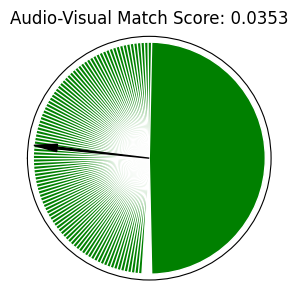


🎯 Score: -0.0542 → ❌ MISMATCH


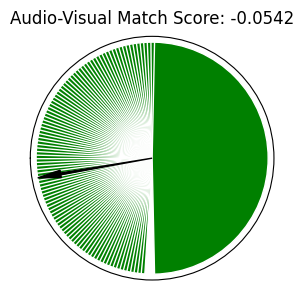

In [35]:
results = []

# ✅ MATCH CASE — using the same video file for both video and audio
match_score, match_label = display_match_result("/content/video1.mp4", "/content/match-audio.mp3")
results.append(["video1.mp4", "match-audio.mp3", round(match_score, 4), match_label])

# ❌ MISMATCH CASE — using unrelated or wrong audio
mismatch_score, mismatch_label = display_match_result("/content/video1.mp4", "/content/mismatch-audio-1.mp3")
results.append(["video1.mp4", "mismatch-audio-1.mp3", round(mismatch_score, 4), mismatch_label])


In [36]:
import pandas as pd

df = pd.DataFrame(results, columns=["Video", "Audio", "Cosine Score", "Result"])
print("📊 Evaluation Summary:")
df.style.set_properties(**{'text-align': 'center'})


📊 Evaluation Summary:


,Video,Audio,Cosine Score,Result
0,video1.mp4,match-audio.mp3,0.035300,✅ MATCH
1,video1.mp4,mismatch-audio-1.mp3,-0.054200,❌ MISMATCH
